## Improt libraries

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score,precision_recall_curve,average_precision_score, recall_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
import joblib
from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading

In [103]:
candidates = [
    Path("winequality-red.csv"),
    Path("../data/raw/winequality-red.csv"),
    Path("../../data/raw/winequality-red.csv"),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError("winequality-red.csv not found in expected paths.")

df = pd.read_csv(csv_path)
print("Loaded:", csv_path.resolve())
print(df.shape)

Loaded: /workspaces/ML-Wine-Predicting-Model-CS1/wine_quality_predicting_model/data/raw/winequality-red.csv
(1599, 12)


In [104]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [105]:
#checking for null values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Data Analysis and Visulaization

### 1. Class distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

/tmp/ipykernel_1785/1821244884.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


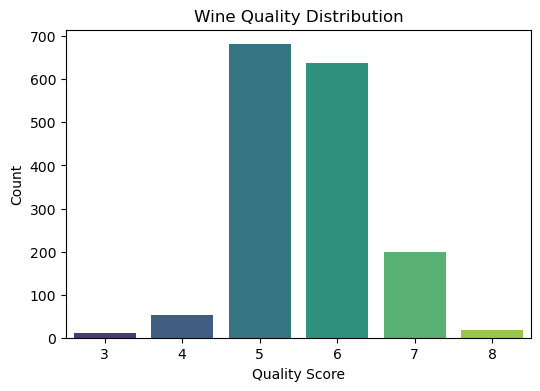

In [106]:
# Quick overview of data
print(df.info())
print(df.describe())

# Check class balance
plt.figure(figsize=(6,4))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Wine Quality Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()


### 2. Feature Distributions

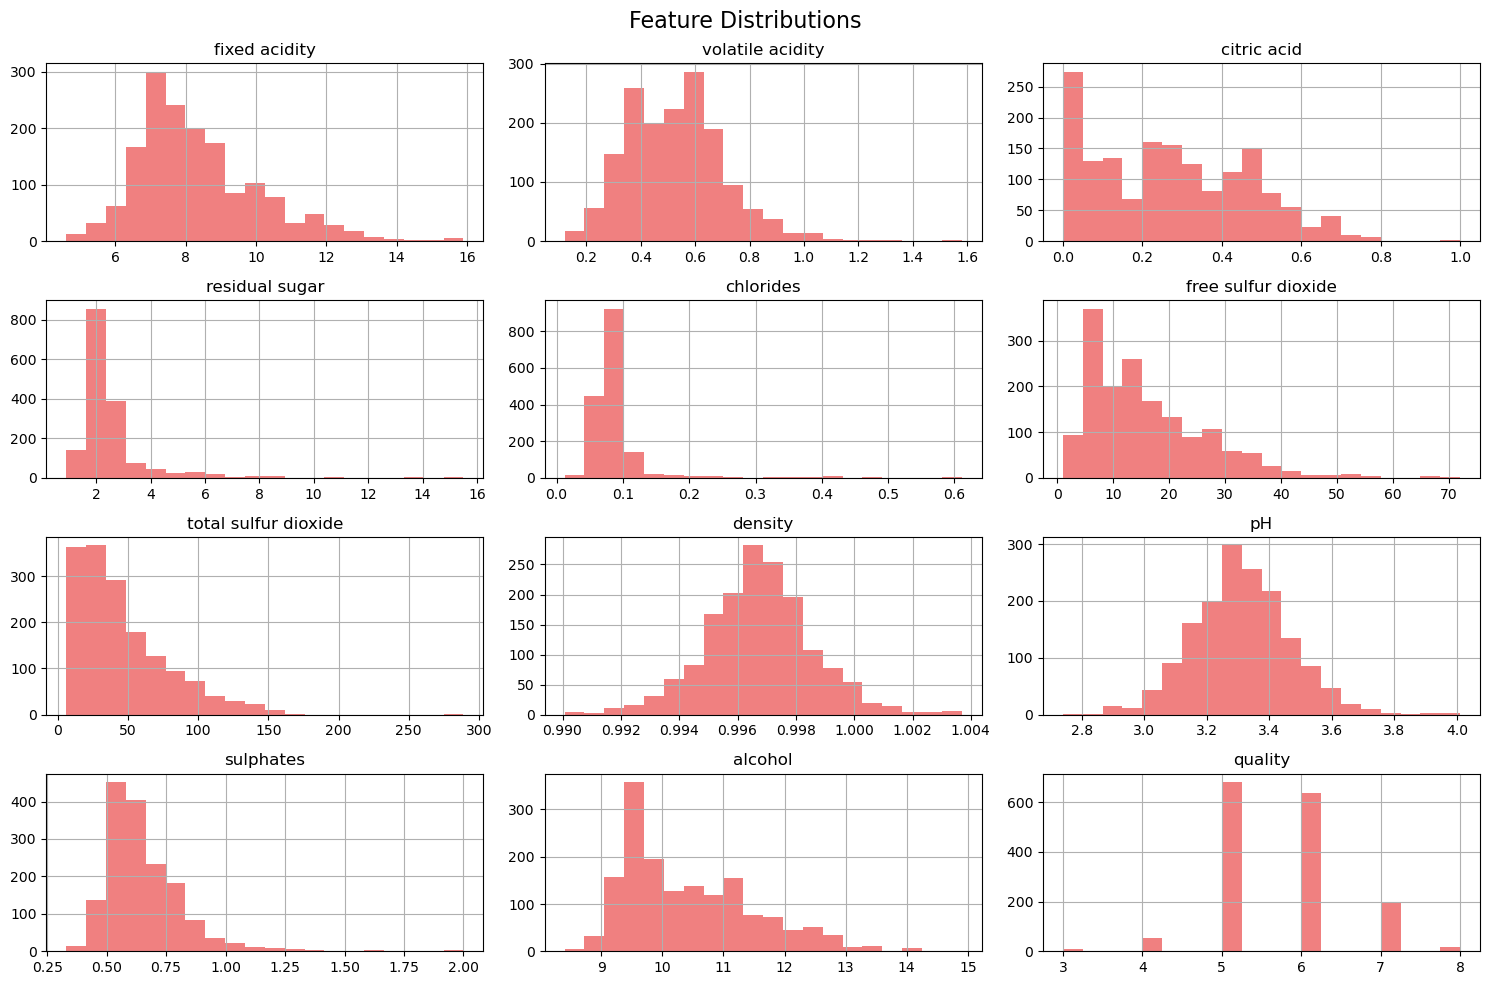

In [107]:
# Plot distributions for all features
df.hist(bins=20, figsize=(15,10), color='lightcoral')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

### 3. Boxplots by Quality (Feature vs Target)

/tmp/ipykernel_1785/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_1785/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_1785/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_1785/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` var

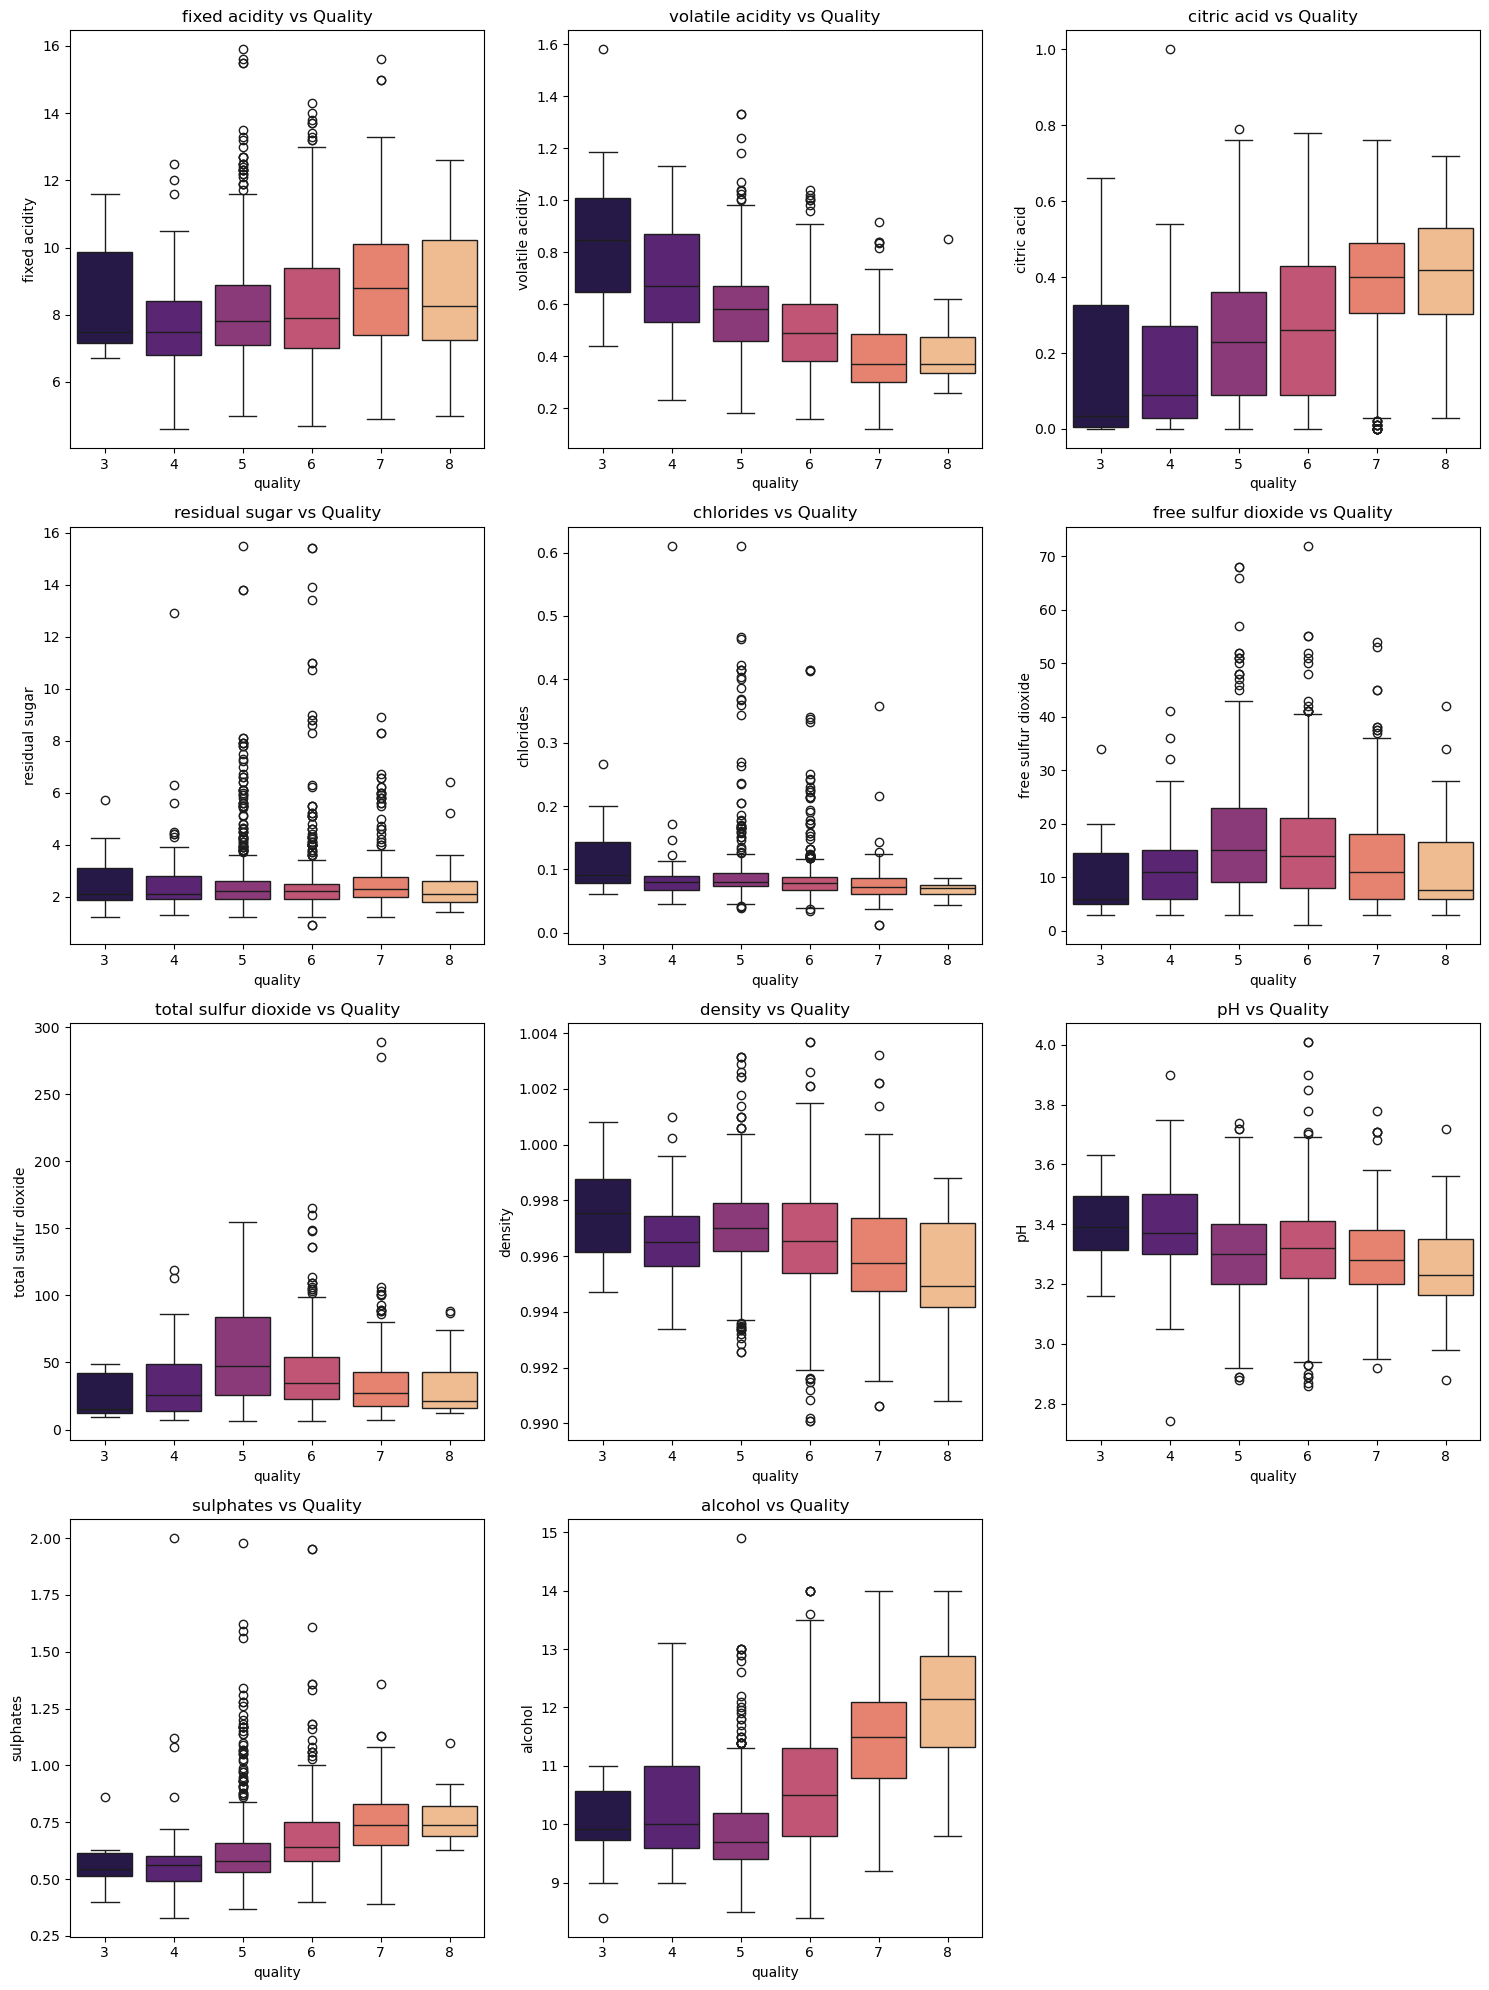

In [108]:
# Boxplot of each feature grouped by wine quality
features = df.columns[:-1]  # Exclude 'quality'

plt.figure(figsize=(15, 20))
for i, col in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='quality', y=col, data=df, palette='magma')
    plt.title(f'{col} vs Quality')

plt.tight_layout()
plt.show()

### 4. Correlation Heatmap

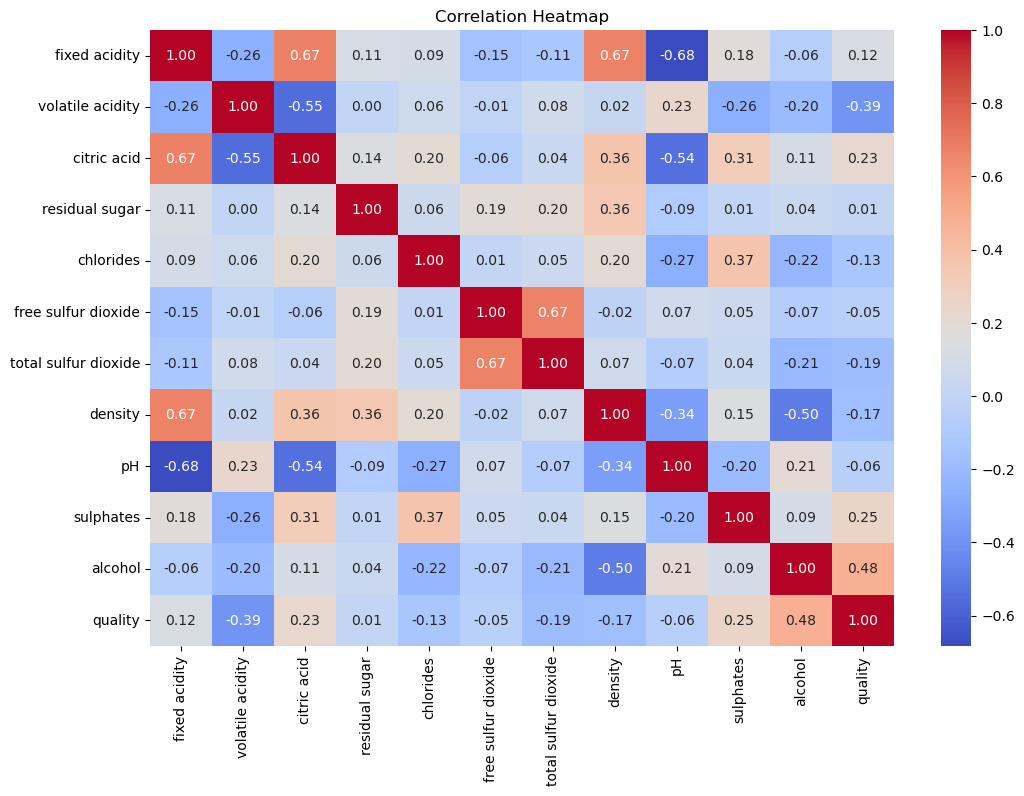

In [109]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### 5. Pairplot

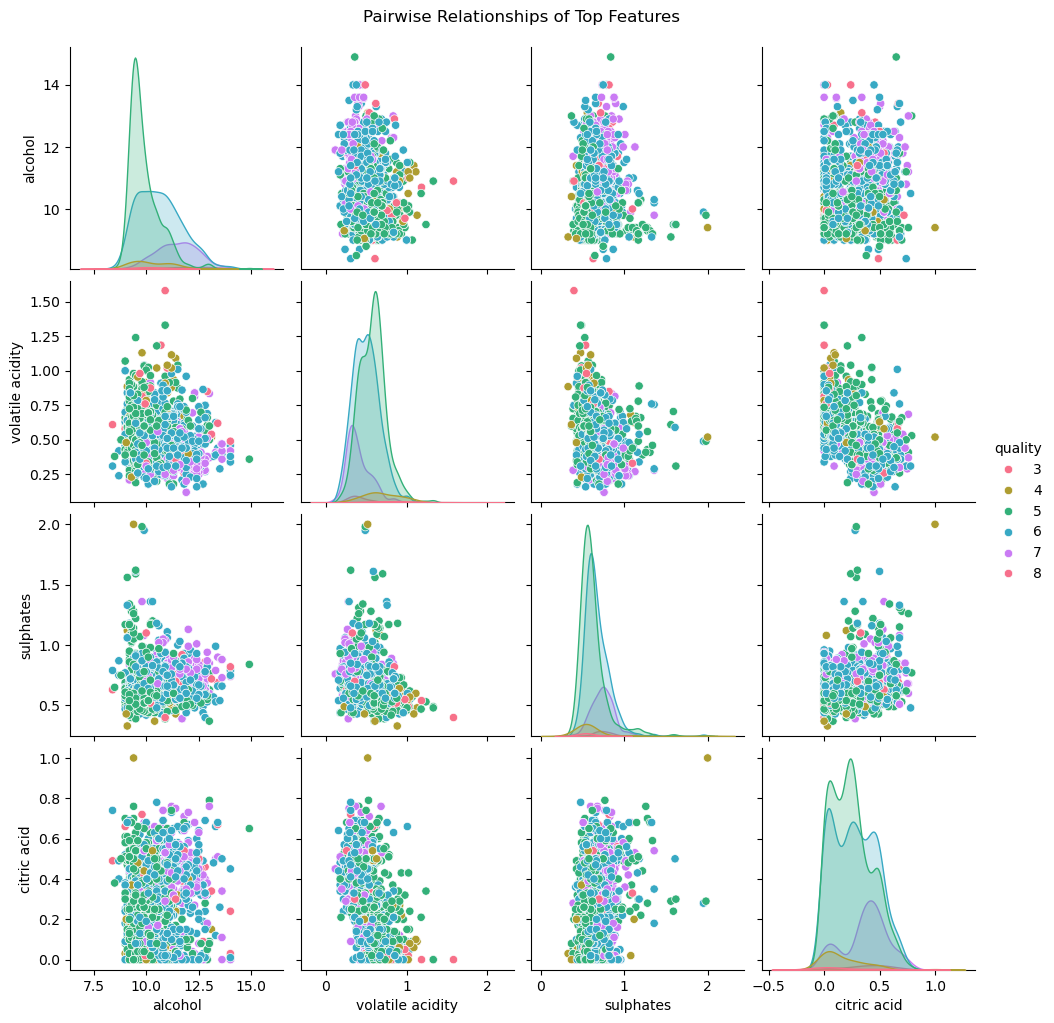

In [110]:
# Pick top correlated features with quality
top_corr_features = corr['quality'].abs().sort_values(ascending=False)[1:5].index.tolist()

# Pairplot
sns.pairplot(df, vars=top_corr_features, hue='quality', palette='husl')
plt.suptitle("Pairwise Relationships of Top Features", y=1.02)
plt.show()

## Data Preprocessing

In [111]:
# Check missing values
print(f"\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")


Missing values:
No missing values found!


In [112]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 240


## Data Cleaning

In [113]:
initial_shape = df.shape
print(f"Initial dataset shape: {initial_shape}")

Initial dataset shape: (1599, 12)


In [114]:
# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

After removing duplicates: (1359, 12)


In [115]:
if df.duplicated().sum() > 0:
    print("\nDuplicate rows (before removal):")
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)))
    df = df.drop_duplicates()
    print(f"\nRemoved {df.duplicated().sum()} duplicates. New shape:", df.shape)


Duplicate rows (before removal):
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
142             5.2             0.340         0.00             1.8      0.050   
144             5.2             0.340         0.00             1.8      0.050   
131             5.6             0.500         0.09             2.3      0.049   
132             5.6             0.500         0.09             2.3      0.049   
1488            5.6             0.540         0.04             1.7      0.049   
...             ...               ...          ...             ...        ...   
391            13.7             0.415         0.68             2.9      0.085   
243            15.0             0.210         0.44             2.2      0.075   
244            15.0             0.210         0.44             2.2      0.075   
554            15.5             0.645         0.49             4.2      0.095   
555            15.5             0.645         0.49             4.2      0.0

In [116]:
print("\nNumber of duplicates:", df.duplicated().sum())


Number of duplicates: 0


In [117]:
# Handle missing values (No any missing values hear)
if df_clean.isnull().sum().sum() > 0:
    print("Handling missing values...")
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numerical_cols] = df_clean[numerical_cols].fillna(df_clean[numerical_cols].median())
    print("Missing values filled with median")

## Feature Engineering

### 1. create binary target column

In [118]:
# Create binary classification label: 1 for good quality (>=7), 0 for not good
df = df.copy()
df['quality_label'] = (df['quality'] >= 7).astype(int)
label_counts = df['quality_label'].value_counts()
print('Label counts:\n', label_counts)

Label counts:
 quality_label
0    1175
1     184
Name: count, dtype: int64


### 2. Feature-Target Split

In [119]:
# Drop 'quality' and use 'quality_label' as target
FEATURES = [c for c in df.columns if c not in ['quality', 'quality_label']]
TARGET = 'quality_label'
X = df[FEATURES]
y = df[TARGET]


### 3. Train-Test Split

In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((1087, 11), (272, 11), 0.13523459061637536, 0.13602941176470587)

## Pipeline & Hyperparameter Tuning

combine `StandardScaler` with `LogisticRegression` in a `Pipeline` and use **GridSearchCV**.

In [121]:
# Class weights to mitigate imbalance if present
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print('Class weights:', class_weight_dict)

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

param_grid = {
    'clf__penalty': ['l2'],                 # 'l1' requires liblinear/saga; l2 is stable
    'clf__C': [0.01, 0.1, 1.0, 3.0, 10.0],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__class_weight': [class_weight_dict, None],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV ROC-AUC:', grid.best_score_)
best_model = grid.best_estimator_

Class weights: {0: 0.5781914893617022, 1: 3.697278911564626}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.8655502567865005


## Evaluation on the held-out Test set

Accuracy : 0.875
Precision: 0.636
Recall   : 0.189
ROC-AUC  : 0.881

Classification Report
               precision    recall  f1-score   support

           0      0.885     0.983     0.931       235
           1      0.636     0.189     0.292        37

    accuracy                          0.875       272
   macro avg      0.761     0.586     0.612       272
weighted avg      0.851     0.875     0.844       272



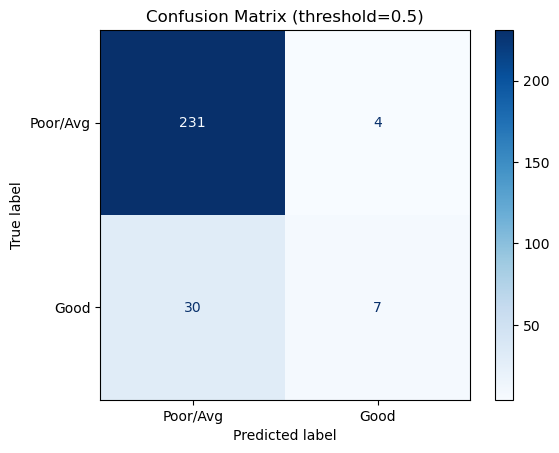

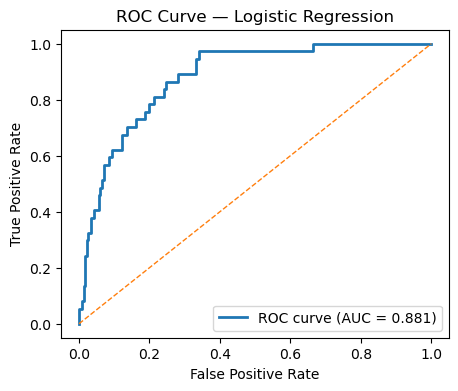

In [122]:
# Predict probabilities for ROC-AUC
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
rocauc = roc_auc_score(y_test, y_proba)

print(f'Accuracy : {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall   : {rec:.3f}')
print(f'ROC-AUC  : {rocauc:.3f}')

print('\nClassification Report\n', classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor/Avg', 'Good'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (threshold=0.5)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {rocauc:.3f})')
plt.plot([0,1],[0,1], linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.legend(loc='lower right')
plt.show()

## Tune the decision threshold

In [123]:
# Tune the decision threshold to improve F1 / recall

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = f1.argmax()
best_thr = float(thr[best_idx])

print(f"Best F1 threshold: {best_thr:.3f}, F1={f1[best_idx]:.3f}, "
      f"Precision={prec[best_idx]:.3f}, Recall={rec[best_idx]:.3f}")

# Re-evaluate metrics at tuned threshold
y_pred = (y_proba >= best_thr).astype(int)
acc = accuracy_score(y_test, y_pred)
prec_at = precision_score(y_test, y_pred, zero_division=0)
rec_at  = recall_score(y_test, y_pred, zero_division=0)
f1_at   = (2 * prec_at * rec_at) / (prec_at + rec_at + 1e-12)

print("\n@ tuned threshold")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec_at:.3f}")
print(f"Recall   : {rec_at:.3f}")
print(f"F1       : {f1_at:.3f}")

Best F1 threshold: 0.393, F1=0.561, Precision=0.511, Recall=0.622

@ tuned threshold
Accuracy : 0.868
Precision: 0.511
Recall   : 0.622
F1       : 0.561


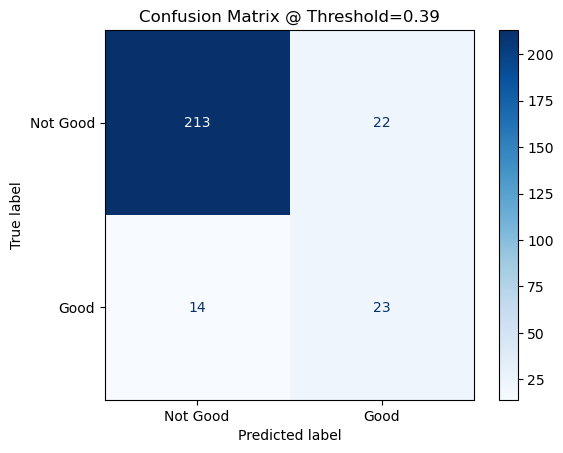

In [124]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix @ Threshold={best_thr:.2f}")
plt.show()

## Coefficients (Feature importance for LR)

,coefficient
alcohol,0.372807
sulphates,0.193038
volatile acidity,-0.182504
density,-0.142988
chlorides,-0.112552
fixed acidity,0.108796
citric acid,0.104898
total sulfur dioxide,-0.098185
pH,-0.057860
residual sugar,0.055833


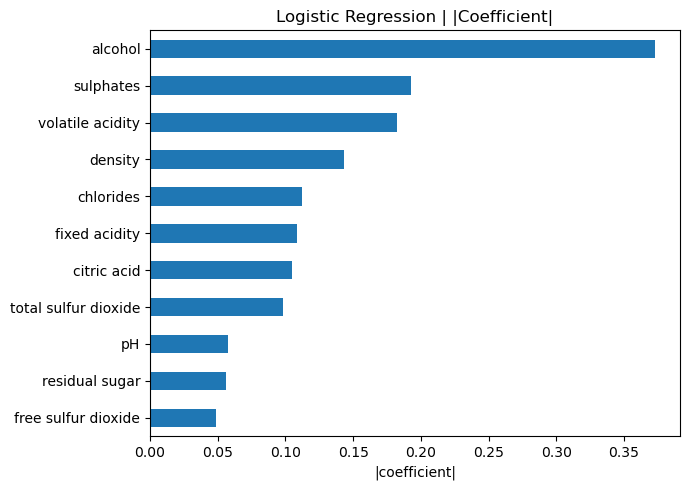

In [125]:
# Extract coefficients from the LR inside the pipeline (after scaling)
lr = best_model.named_steps['clf']
scaler = best_model.named_steps['scaler']

coefs = pd.Series(lr.coef_.ravel(), index=FEATURES).sort_values(key=abs, ascending=False)
display(coefs.to_frame('coefficient').head(15))

# Simple bar plot of absolute coefficients
coefs_abs = coefs.abs().sort_values(ascending=True)
coefs_abs.plot(kind='barh', figsize=(7,5), title='Logistic Regression | |Coefficient|')
plt.xlabel('|coefficient|')
plt.tight_layout()
plt.show()

In [126]:
# Save ROC curve data for Streamlit visualization

fpr, tpr, roc_thr = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "thresholds": roc_thr.tolist(),
    "auc": float(roc_auc),
}

artifact["roc_data"] = roc_data  # <-- Add ROC to model artifact before saving


In [127]:
# Save Precision-Recall curve data for Streamlit visualization

prec, rec, pr_thr = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

pr_data = {
    "precision": prec.tolist(),
    "recall": rec.tolist(),
    "thresholds": pr_thr.tolist(),
    "average_precision": float(ap_score),
}

artifact["pr_data"] = pr_data  # <-- Add PR curve data


## Persist the pipeline (for Streamlit / inference)

In [128]:
# Save model, tuned threshold, and metadata

save_dir = Path("/workspaces/ML-Wine-Predicting-Model-CS1/wine_quality_predicting_model/models/FC211032_VidusahanPerera")
save_dir.mkdir(parents=True, exist_ok=True)

joblib_path = save_dir / "logreg_wine_quality_pipeline.joblib"
pkl_path    = save_dir / "logreg_wine_quality_pipeline.pkl"

artifact = {
    "pipeline": best_model,
    "threshold": best_thr,            # <--- tuned threshold added
    "feature_names": FEATURES,
    "target_name": TARGET,
}

joblib.dump(artifact, joblib_path)
with open(pkl_path, "wb") as f:
    pickle.dump(artifact, f)

print("✅ Model saved successfully!")
print("Saved .joblib to:", joblib_path)
print("Saved .pkl to:", pkl_path)


✅ Model saved successfully!
Saved .joblib to: /workspaces/ML-Wine-Predicting-Model-CS1/wine_quality_predicting_model/models/FC211032_VidusahanPerera/logreg_wine_quality_pipeline.joblib
Saved .pkl to: /workspaces/ML-Wine-Predicting-Model-CS1/wine_quality_predicting_model/models/FC211032_VidusahanPerera/logreg_wine_quality_pipeline.pkl


In [129]:
# Example inference with tuned threshold
model_path = Path("/workspaces/ML-Wine-Predicting-Model-CS1/wine_quality_predicting_model/models/FC211032_VidusahanPerera/logreg_wine_quality_pipeline.joblib")

artifact = joblib.load(model_path)
pipe = artifact["pipeline"]
thr  = artifact.get("threshold", 0.5)

# Example: using mean of training data as a test sample
sample = X_train.mean().to_frame().T
prob = pipe.predict_proba(sample)[0, 1]
label = int(prob >= thr)

print(f"Predicted probability of good wine: {prob:.3f}")
print(f"Predicted label @thr={thr:.2f}: {'Good (≥7)' if label==1 else 'Not Good (<7)'}")


Predicted probability of good wine: 0.228
Predicted label @thr=0.39: Not Good (<7)
